In [1]:
import pandas as pd
import numpy as np
import dtale
import os 
os.chdir("../..")
path="data/train.parquet"

/Users/isaac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/isaac/Library/Python/3.9/lib/python/site-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

In [4]:
df = pd.read_parquet(path)

In [ ]:
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel"] 
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]
data = df[cols_cat+numeric_cols].copy()
cat = (
    df["categories"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)
genre = (
    df["genres"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)
tags = (
    df["tags_utilisateurs"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)
lang_dummies_p = (
    df["langues_partiel"]
    .explode()
    .str.get_dummies()
    .groupby(level=0)
    .max()
    .add_prefix("lang_p_")
)

X = pd.concat(
    [
        data,
        cat,
        genre,
        tags,
        lang_dummies_p,
    ],
    axis=1
)
Y = df["succes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train[numeric_cols] = X_train[numeric_cols].astype(float)
X_test[numeric_cols] = X_test[numeric_cols].astype(float)
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

In [ ]:
model =  LogisticRegression(
    solver="saga",         # rapide pour beaucoup de features + sparse
    penalty="l2",          # régularisation L2 classique
    max_iter=5000,         
    n_jobs=-1,             # multicore si possible
    verbose=100,             # pour suivre la progression
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
Epoch 1, change: 1
Epoch 2, change: 0.3256211
Epoch 3, change: 0.17495277
Epoch 4, change: 0.12298808
Epoch 5, change: 0.091967857
Epoch 6, change: 0.071070778
Epoch 7, change: 0.057244979
Epoch 8, change: 0.049074772
Epoch 9, change: 0.040587235
Epoch 10, change: 0.036245101
Epoch 11, change: 0.032307718
Epoch 12, change: 0.028530306
Epoch 13, change: 0.02634005
Epoch 14, change: 0.024051525
Epoch 15, change: 0.022433359
Epoch 16, change: 0.020564056
Epoch 17, change: 0.019054838
Epoch 18, change: 0.017465338
Epoch 19, change: 0.01638485
Epoch 20, change: 0.015400773
Epoch 21, change: 0.014316636
Epoch 22, change: 0.013520141
Epoch 23, change: 0.012604428
Epoch 24, change: 0.01197513
Epoch 25, change: 0.011255349
Epoch 26, change: 0.010700198
Epoch 27, change: 0.010211512
Epoch 28, change: 0.0095491108
Epoch 29, change: 0.0091122705
Epoch 30, change: 0.0086698366
Epoch 31, change: 0.0083209026
Epoch 32, c

Champion AUC : 0.8346
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      9416
        True       0.15      0.79      0.26       258

    accuracy                           0.88      9674
   macro avg       0.57      0.83      0.60      9674
weighted avg       0.97      0.88      0.92      9674



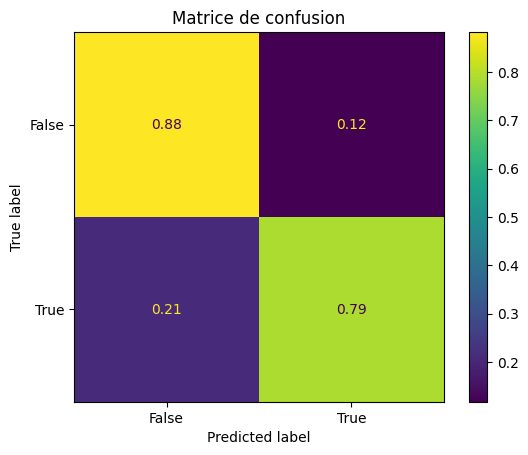

In [11]:
auc= roc_auc_score(y_test, y_pred)

# --- RESULTAT ---
print(f"Champion AUC : {auc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true"  
)

plt.title("Matrice de confusion")
plt.show()

Champion AUC : 0.6371
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      9416
        True       0.61      0.28      0.38       258

    accuracy                           0.98      9674
   macro avg       0.80      0.64      0.69      9674
weighted avg       0.97      0.98      0.97      9674



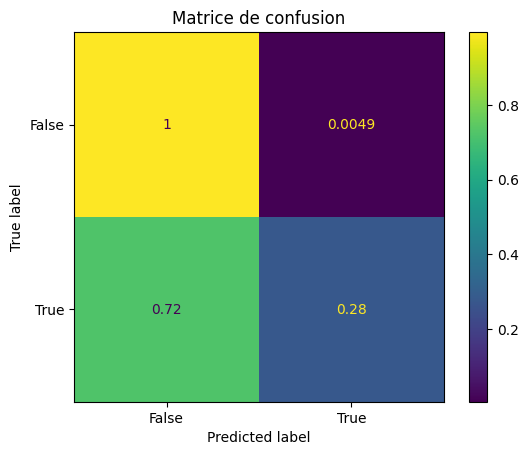

In [ ]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64), # Deux couches cachées
    activation='relu',
    solver='adam',
    alpha=0.0001, # Régularisation L2 (pour éviter l'overfitting)
    batch_size=64,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True, 
    random_state=42
)

mlp.fit(X_train, y_train) 
y_pred = mlp.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

# --- RESULTAT ---
print(f"Champion AUC : {auc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true" 
)

plt.title("Matrice de confusion")
plt.show()

Learning rate set to 0.049076
0:	total: 1.01s	remaining: 16m 50s
100:	total: 1m 41s	remaining: 15m 6s
200:	total: 3m 20s	remaining: 13m 17s
300:	total: 4m 58s	remaining: 11m 32s
400:	total: 6m 40s	remaining: 9m 58s
500:	total: 8m 28s	remaining: 8m 26s
600:	total: 10m 9s	remaining: 6m 44s
700:	total: 11m 55s	remaining: 5m 5s
800:	total: 13m 37s	remaining: 3m 23s
900:	total: 15m 16s	remaining: 1m 40s
999:	total: 17m 5s	remaining: 0us
Champion AUC : 0.7705
              precision    recall  f1-score   support

       False       0.99      0.98      0.98      9416
        True       0.38      0.57      0.46       258

    accuracy                           0.96      9674
   macro avg       0.69      0.77      0.72      9674
weighted avg       0.97      0.96      0.97      9674



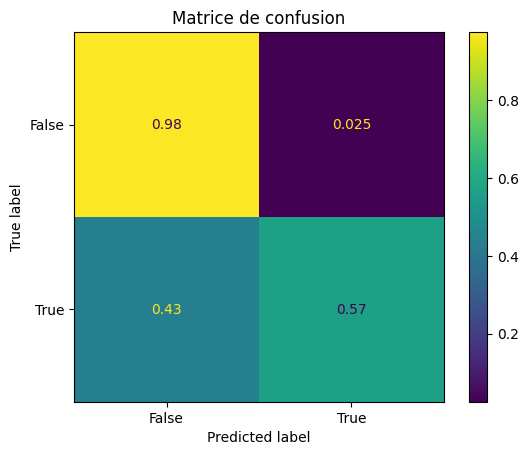

In [6]:

# --- MODELE B : CHAMPION (CatBoost Full) ---
cols_text = ["categories","genres","tags_utilisateurs","langues_partiel","langues_complet"] 
cols_cat = ["support_manette"]
numeric_cols = ["prix","nombre_succes","N_langues_complet","N_langues_partiel"]

features = numeric_cols+ cols_cat + cols_text
target = "succes"

X = df[features].copy()
for c in cols_text: X[c] = X[c].apply(clean_text_col) 
Y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

cat = CatBoostClassifier(
    depth=10,
    text_features=cols_text,
    cat_features=cols_cat,
    verbose=100,
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    task_type="CPU" ,
    eval_metric='AUC'  
)

cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

# --- RESULTAT ---
print(f"Champion AUC : {auc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize="true" 
)

plt.title("Matrice de confusion")
plt.show()